# Variação de seção do poço


Arquivo de configuração


In [28]:
from modules.simulation.config.model import SimulationConfigModel
import pathlib

case_data = {
    "poco_reto": {"title": "Poço reto"},
    "2_fases": {"title": "2 fases"},
    "4_fases": {"title": "4 fases"},
}

for case in case_data.keys():
    cfg_path = pathlib.Path(f"./docs/source/_static/software/{case}.yaml")
    cfg = SimulationConfigModel.from_file(cfg_path)
    case_data[case]["cfg"] = cfg.model_copy()

case_data

{'poco_reto': {'title': 'Poço reto',
  'cfg': SimulationConfigModel(sim_name='poco_reto', domain=DomainModel(height=0.21, spatial_divisions=220, annular_domain=AnnularDomainModel(internal_radius=0.01, steps=[StepModel(position_z=0.05, radius=0.02)])), suspension=SuspensionModel(initial_conc=0.1391, max_conc=0.19), solid_phase=SolidPhaseModel(particle_diam=4.08e-05, particle_esphericity=0.8, density=2709.0), fluid_phase=FluidPhaseModel(density=891.4, power_law=PowerLawFluidModel(M=30.13, n=0.21)), simulation_parameters=SimulationParameters(timestep=1000.0, total_time=31536000.0), export=FrequencyConfig(frequency=100), report=FrequencyConfig(frequency=1000), HPHT=None, equation_parameters=EquationParameters(delta=0.622641, k0=47.601104, beta=0.04983, ref_conc=0.14, p_ref=63.640954))},
 '2_fases': {'title': '2 fases',
  'cfg': SimulationConfigModel(sim_name='2_fases', domain=DomainModel(height=0.21, spatial_divisions=220, annular_domain=AnnularDomainModel(internal_radius=0.01, steps=[Step

Run simulations


In [29]:
import time
from modules.simulation.sim_handler import SimulationHandler

for case in case_data.keys():
    cfg = case_data[case]["cfg"]
    output_path = pathlib.Path(f"./out/{cfg.sim_name}")
    sim_handler = SimulationHandler(cfg=cfg, output_path=output_path)
    start = time.time()

    sim_handler.start_simulation()

    end = time.time()

    print("\nTempo total de simulação:" + str(end - start) + " [s]")
    print("Status da simulação: " + sim_handler.sim_status)
    print("Exportando resultados...")

    sim_handler.export_sim_data()
    sim_handler.export_domain_polydata(frequency_reduction=100)

[2024-09-08 23:55:05,005] [INFO] - simulation - Starting simulation... (sim_handler.py:87)
[2024-09-08 23:55:05,006] [INFO] - simulation - Current time 0 (sim_handler.py:88)
[2024-09-08 23:55:05,752] [INFO] - simulation - Simulation report: Current time 1000000.0 (sim_handler.py:73)
[2024-09-08 23:55:05,753] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:06,499] [INFO] - simulation - Simulation report: Current time 2000000.0 (sim_handler.py:73)
[2024-09-08 23:55:06,500] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:07,296] [INFO] - simulation - Simulation report: Current time 3000000.0 (sim_handler.py:73)
[2024-09-08 23:55:07,297] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:08,089] [INFO] - simulation - Simulation report: Current time 4000000.0 (sim_handler.py:73)
[2024-09-08 23:55:08,090] [INFO] - simulatio

## Read simulation data


In [30]:
from modules.analysis.results_handler import ResultsHandler
import pathlib

for case in case_data.keys():
    cfg = case_data[case]["cfg"]
    output_path = pathlib.Path(f"./out/{cfg.sim_name}")
    results_handler = ResultsHandler(simulation_path=output_path)
    case_data[case]["results_handler"] = results_handler

Plot concentration


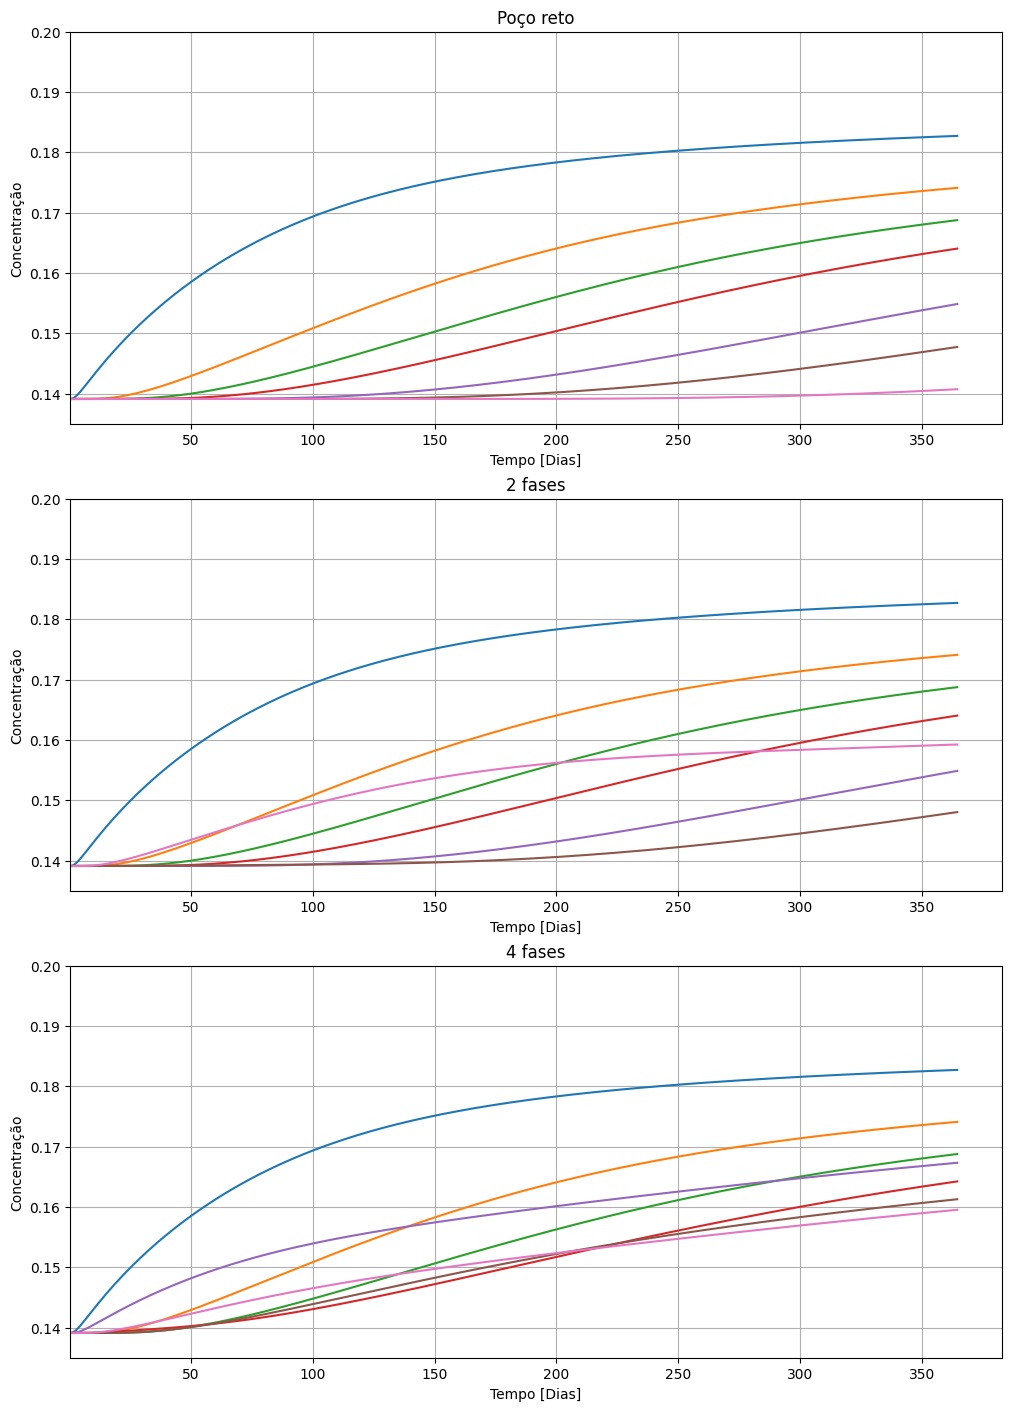

In [31]:
import matplotlib.pyplot as plt

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]
    time, concentration_profiles = results_handler.filter_for_positions(
        variable_name="Concentration", position_values=target_positions
    )

    for position_lbl, concentration_arr in concentration_profiles.items():
        ax.plot(time / (3600 * 24), concentration_arr, label=position_lbl)

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Tempo [Dias]")
    ax.set_xlim(0.400)
    ax.set_ylabel("Concentração")
    ax.set_ylim(0.135, 0.2)
    ax.grid()

    # ax.legend()
plt.show()

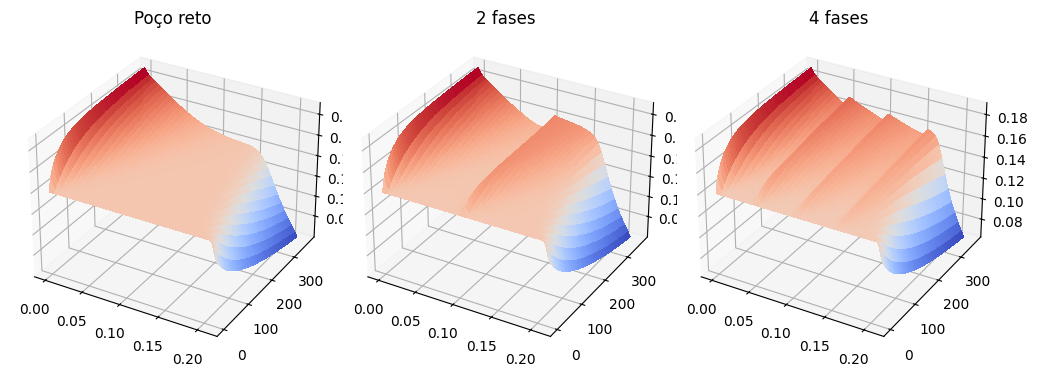

In [32]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(1, (len(case_data) - 1) // 3 + 1),
    min(3, len(case_data)),
    figsize=(10, 14),
    layout="constrained",
    subplot_kw={"projection": "3d"},
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]
    # time, concentration_profiles = results_handler.filter_for_positions(
    #     variable_name="Concentration", position_values=target_positions
    # )

    # for position_lbl, concentration_arr in concentration_profiles.items():
    #     ax.plot(time / (3600 * 24), concentration_arr, label=position_lbl)

    # ax.set_title(case_data[case]["title"])
    # ax.set_xlabel("Tempo [Dias]")
    # ax.set_xlim(0.400)
    # ax.set_ylabel("Concentração")
    # ax.set_ylim(0.135, 0.2)
    # ax.grid()

    X, Y = np.meshgrid(
        results_handler.cell_data["Position"].unique(),
        results_handler.cell_data["Time"].unique() / (3600 * 24),
    )
    Z = (
        results_handler.cell_data["Concentration"]
        .to_numpy()
        .reshape(
            (
                results_handler.cell_data["Time"].nunique(),
                results_handler.cell_data["Position"].nunique(),
            )
        )
    )

    ax.set_title(case_data[case]["title"])
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # ax.plot_surface(Z, Y, X, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # ax.legend()
plt.show()

Plot permeability


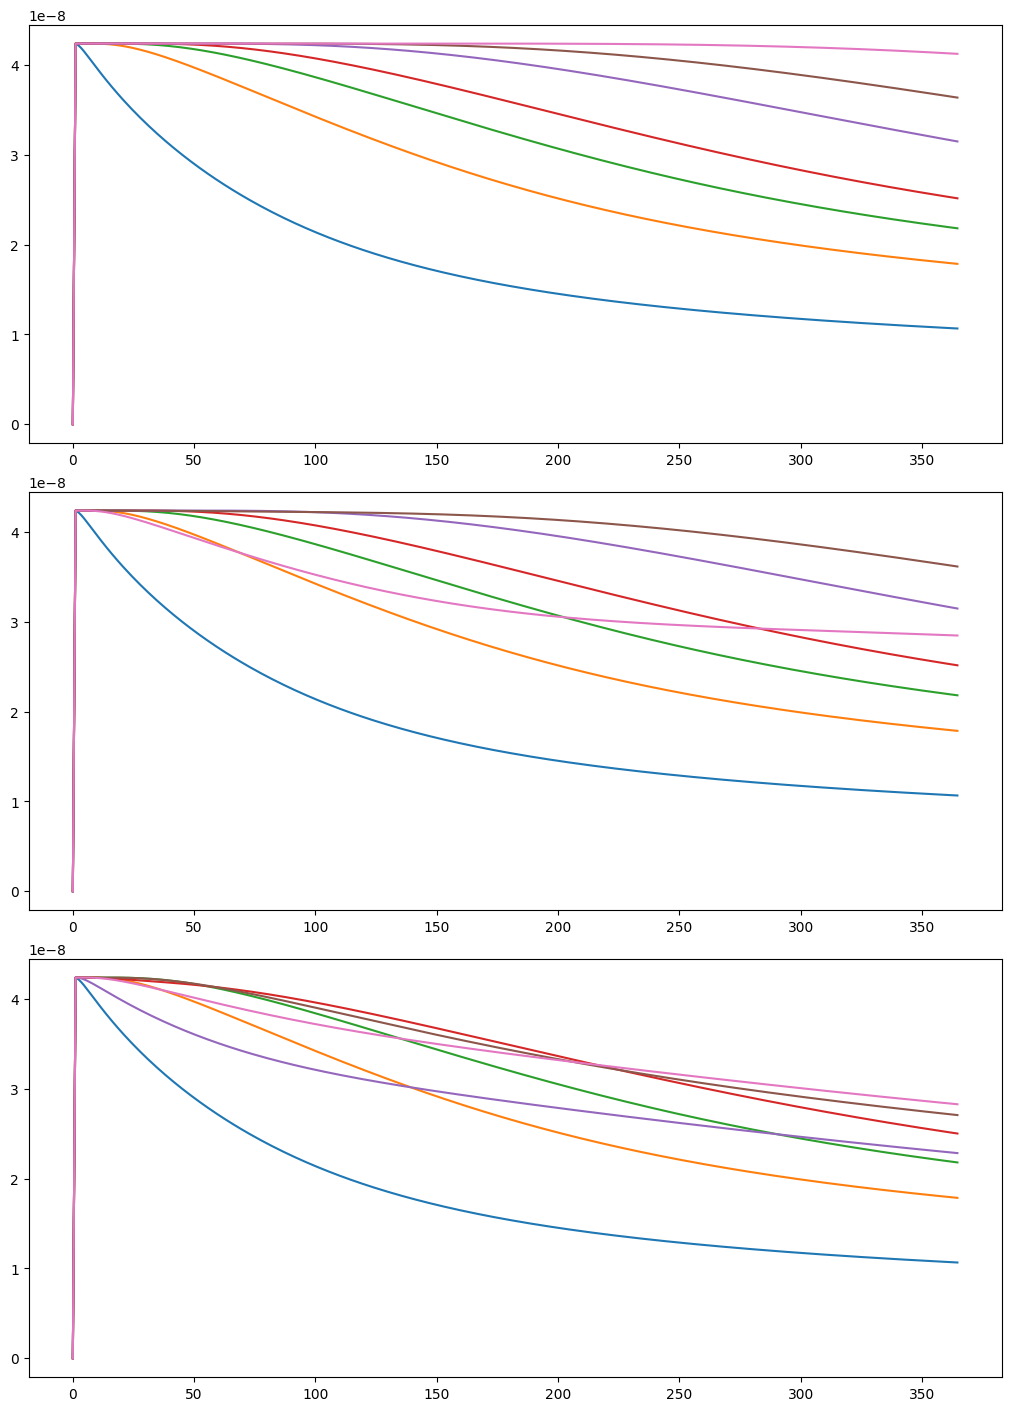

In [33]:
import matplotlib.pyplot as plt

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]

    time, perm_profiles = results_handler.filter_for_positions(
        variable_name="Permeability", position_values=target_positions
    )

    for position_lbl, perm_arr in perm_profiles.items():
        ax.plot(time / (3600 * 24), perm_arr, label=position_lbl)

    # ax.legend()
plt.show()

Plot pressure gradient


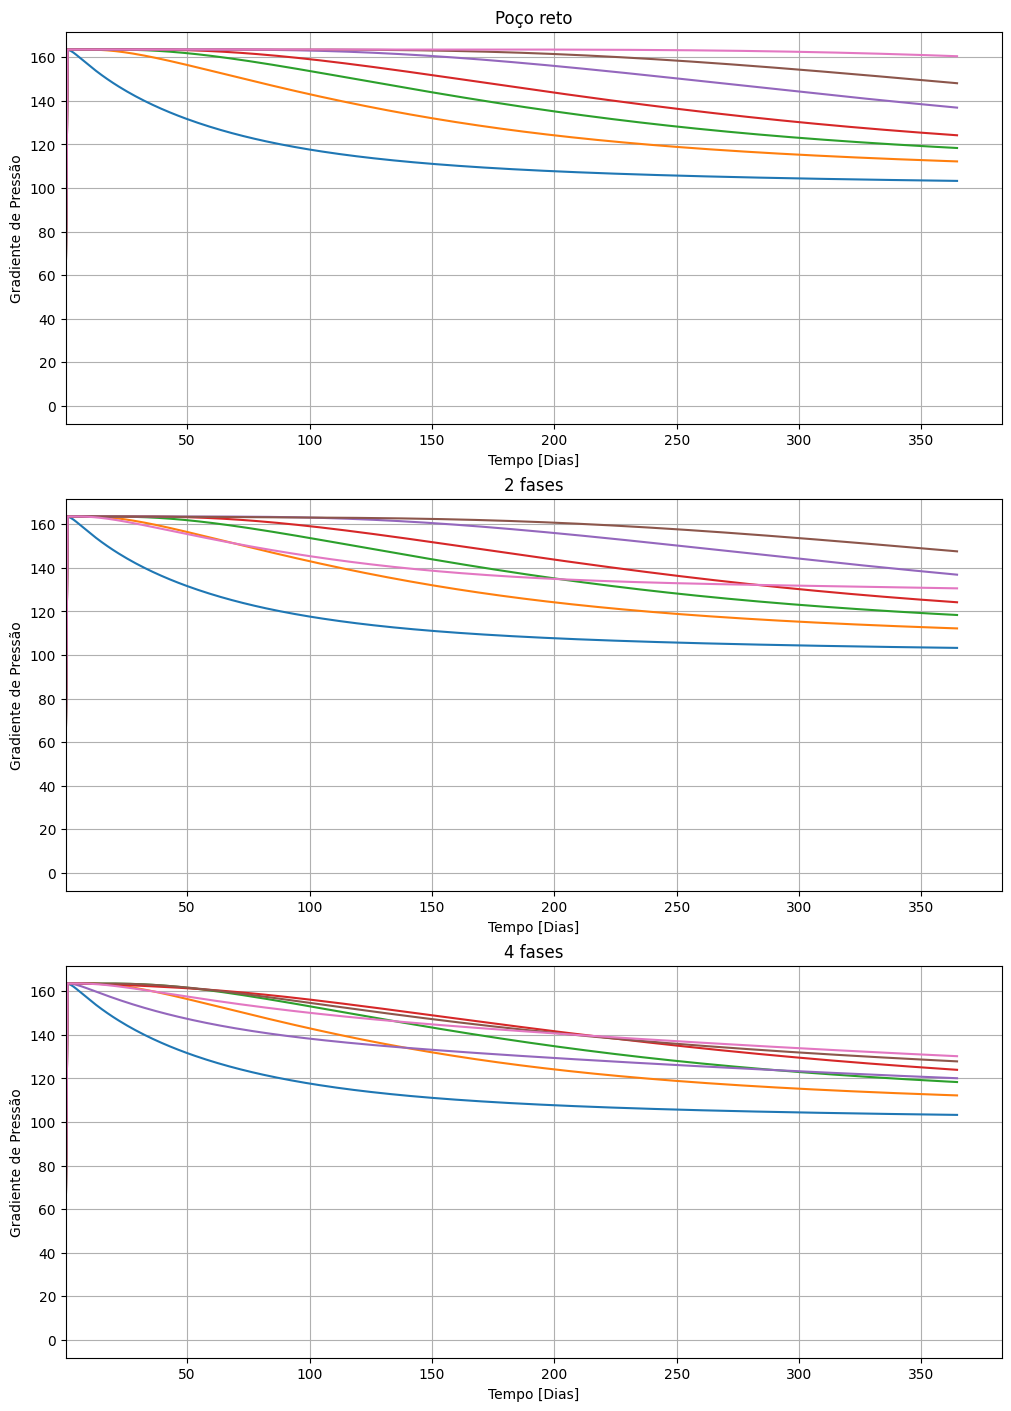

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]

    time, pressure_grad_profiles = results_handler.filter_for_positions(
        variable_name="Pressure_Gradient", position_values=target_positions
    )

    for position_lbl, pressure_grad in pressure_grad_profiles.items():
        ax.plot(time / (3600 * 24), pressure_grad, label=position_lbl)

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Tempo [Dias]")
    ax.set_xlim(0.400)
    ax.set_ylabel("Gradiente de Pressão")
    ax.grid()

    # ax.legend()
plt.show()